In [55]:
from skimage import io, color, morphology
from skimage.color import rgb2gray

from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb
import os
from scipy import stats
import pandas as pd
import seaborn as sns

In [56]:
BASEDIR = "data/"
FILENAME = "lego_4_small.png"
FILEPATH = os.path.join(BASEDIR, FILENAME)

sns.set_theme(style="whitegrid")


In [57]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

def plot_comparison(original, filtered, filter_name, original_name = "Original"):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title(original_name)
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    io.show()
    
# UTILITY FUNCTIONS

    
def threshold_image(img_in, thres: int | float | list[float] | list[int], inverted : bool = False):
    """
    Apply a threshold in an image and return the resulting image
    :param img_in: Input image
    :param thres: The treshold value in the range [0, 255]
    :return: Resulting image (unsigned byte) where background is 0 and foreground is 255
    """
    
    if isinstance(thres, list):
        raise NotImplementedError("Not implemented for list")
    elif isinstance(thres, int) or isinstance(thres, float):
        img_out = np.zeros(img_in.shape)
        
        if inverted:
            img_out[img_in < thres] = 1
        else:
            img_out[img_in > thres] = 1
    
    return img_out

def compute_outline(bin_img):
    """
    Computes the outline of a binary image
    """
    footprint = morphology.disk(1)
    dilated = dilation(bin_img, footprint)
    outline = np.logical_xor(dilated, bin_img)
    return outline
    
def compute_blob_circularity(A : float, P : float) -> float:
    """
    Computes the circularity of a blob given A the area of the object
    and P the perimeter of the object
    A Circle has a circularity close to 1 and very-non-circular object have circularity close to 0.
    """
    return (4 * math.pi * A) / (P ** 2)

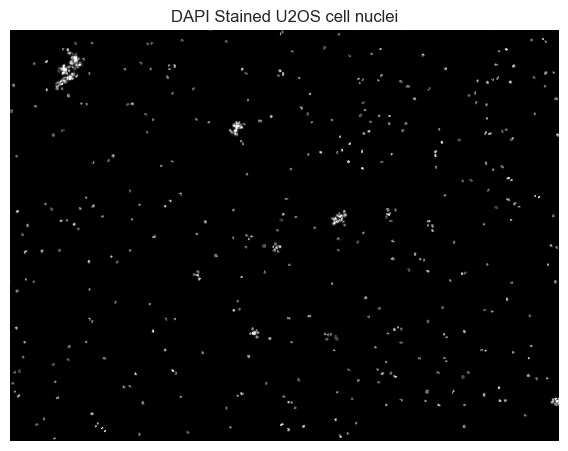

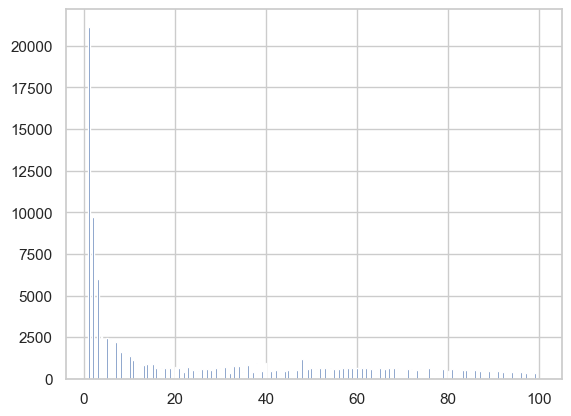

In [58]:
in_dir = "data/"
img_org = io.imread(in_dir + "Sample E2 - U2OS DAPI channel.tiff")
# slice to extract smaller image
img_small = img_org[:]
img_gray = img_as_ubyte(img_small)
io.imshow(img_gray, vmin=0, vmax=150)
plt.title("DAPI Stained U2OS cell nuclei")
plt.axis("off")
io.show()
# avoid bin with value 0 due to the very large number of background pixels
plt.hist(img_gray.ravel(), bins=256, range=(1, 100))
io.show()

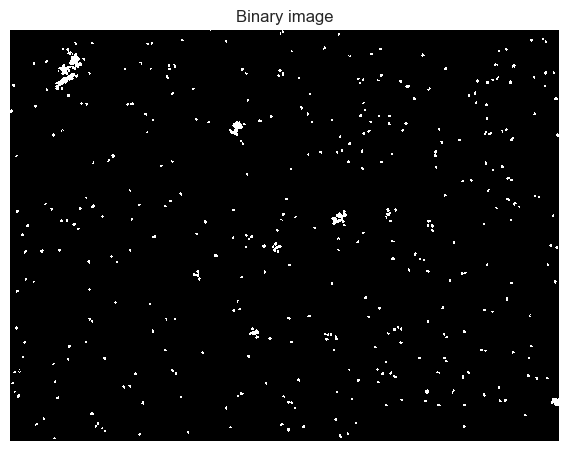

In [59]:
thresh = threshold_otsu(img_gray)
bin_image = img_gray > thresh
io.imshow(bin_image)
plt.title("Binary image")
plt.axis("off")
plt.show()

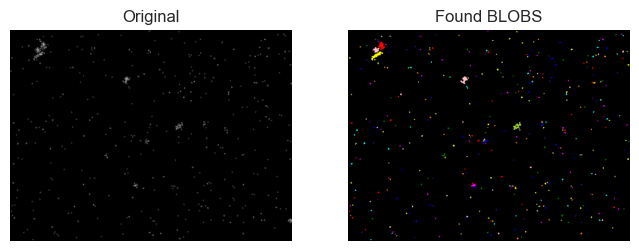

In [60]:
img_c_b = segmentation.clear_border(bin_image)

label_img = measure.label(img_c_b)
image_label_overlay = label2rgb(label_img)
plot_comparison(img_gray, image_label_overlay, 'Found BLOBS')

## EX 10

In [61]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])



DescribeResult(nobs=378, minmax=(1.0, 1583.0), mean=94.21693121693121, variance=22120.95016350189, skewness=8.19993292738498, kurtosis=69.44903929260276)


,Area [Pixels]
count,378.000000
mean,94.216931
std,148.731134
min,1.000000
25%,60.000000
50%,69.000000
75%,92.000000
max,1583.000000


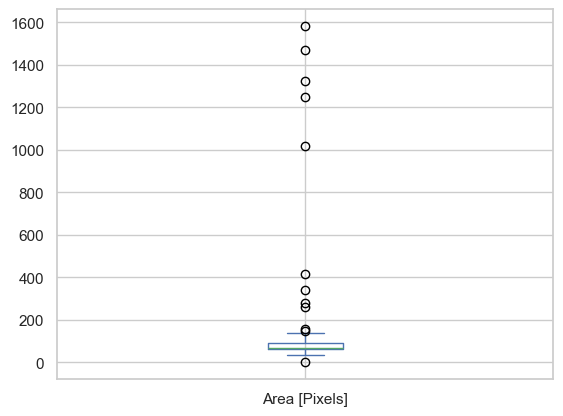

In [62]:
print(stats.describe(areas))
pd.DataFrame(areas, columns=["Area [Pixels]"]).plot(kind='box')
pd.DataFrame(areas, columns=["Area [Pixels]"]).describe()


Min area:  1.0
Max area:  122.0


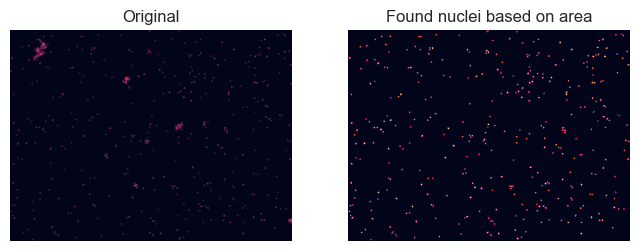

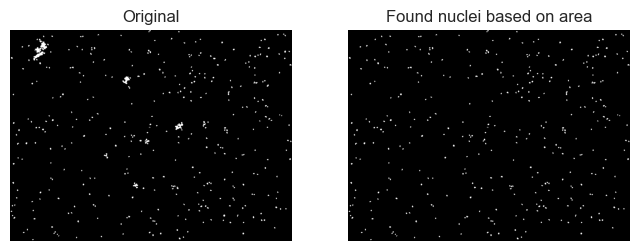

In [63]:
min_area = np.quantile(areas, 0)
max_area = np.quantile(areas, 0.95)

print("Min area: ", min_area)
print("Max area: ", max_area)

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0 
show_comparison(img_small, i_area, 'Found nuclei based on area')
plot_comparison(img_c_b, i_area, 'Found nuclei based on area')

DescribeResult(nobs=378, minmax=(0.0, 292.492424049175), mean=35.20826307043834, variance=719.1055387289305, skewness=7.523246221556217, kurtosis=60.54136215863047)


,Area [Pixels]
count,378.000000
mean,35.208263
std,26.816143
min,0.000000
25%,27.899495
50%,30.970563
75%,35.152543
max,292.492424


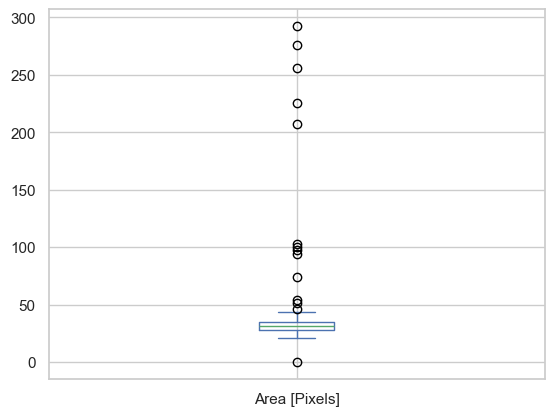

In [64]:
perimeters = np.array([prop.perimeter for prop in region_props])

print(stats.describe(perimeters))
pd.DataFrame(perimeters, columns=["Area [Pixels]"]).plot(kind='box')
pd.DataFrame(perimeters, columns=["Area [Pixels]"]).describe()


Min perimeter:  0.0
Max perimeter:  42.512646071181756


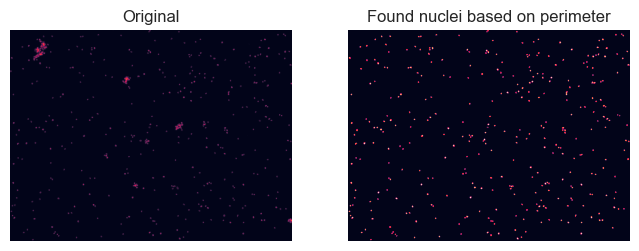

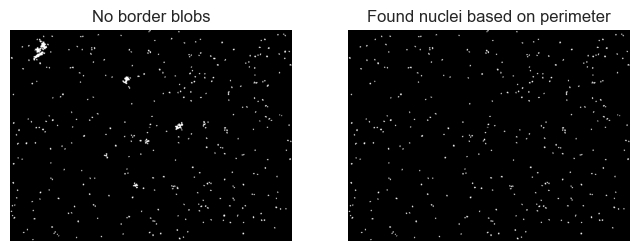

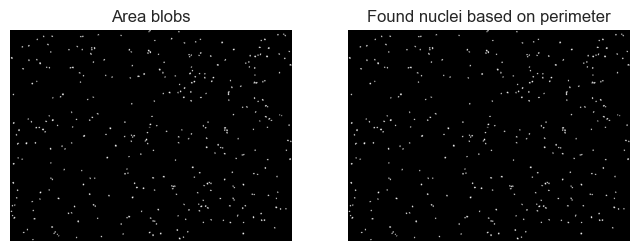

In [65]:
min_perimeter = np.quantile(perimeters, 0)
max_perimeter = np.quantile(perimeters, 0.95)

print("Min perimeter: ", min_perimeter)
print("Max perimeter: ", max_perimeter)

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.perimeter > max_perimeter or region.perimeter < min_perimeter:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_perimeter = label_img_filter > 0 
show_comparison(img_small, i_perimeter, 'Found nuclei based on perimeter')
plot_comparison(img_c_b, i_perimeter, 'Found nuclei based on perimeter', original_name="No border blobs")
plot_comparison(i_area, i_perimeter, 'Found nuclei based on perimeter', original_name="Area blobs")

C:\Users\marku\AppData\Local\Temp\ipykernel_3412\3590036340.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  return (4 * math.pi * A) / (P ** 2)


<Axes: >

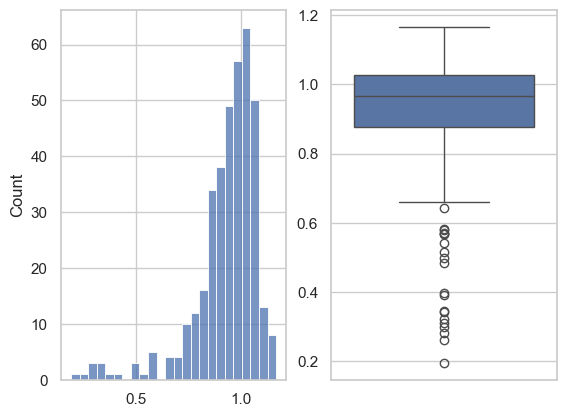

In [66]:
blob_circularities = np.array([compute_blob_circularity(prop.area, prop.perimeter) for prop in region_props])
fig, ax = plt.subplots(1, 2)
sns.histplot(blob_circularities, ax=ax[0])
sns.boxplot(blob_circularities, ax=ax[1])

Min circularity:  0.877781600561755
Max circularity:  inf
Number of blobs:  284


C:\Users\marku\AppData\Local\Temp\ipykernel_3412\3590036340.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  return (4 * math.pi * A) / (P ** 2)


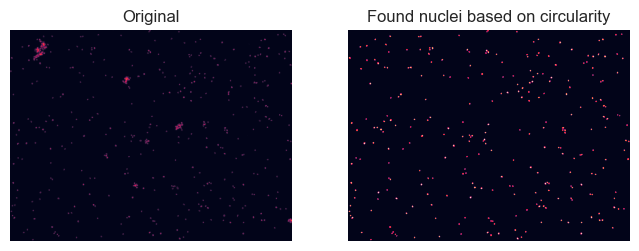

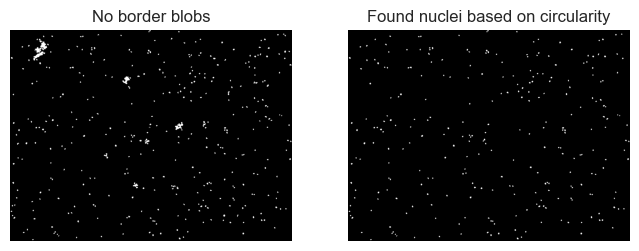

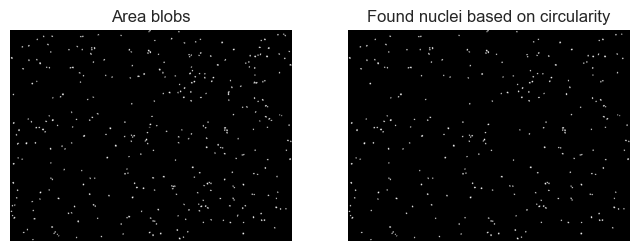

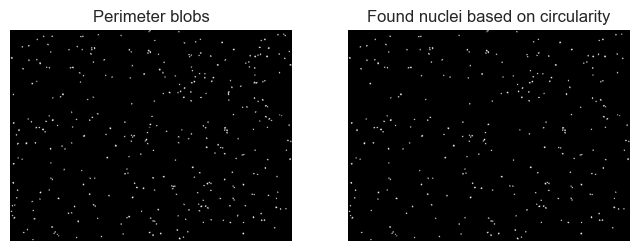

In [67]:
min_circularity = np.quantile(blob_circularities, 0.25)
max_circularity = np.quantile(blob_circularities, 1)

print("Min circularity: ", min_circularity)
print("Max circularity: ", max_circularity)

# Create a copy of the label_img
label_img_filter = label_img
count = 0
for region in region_props:
    if compute_blob_circularity(region.area, region.perimeter) > max_circularity or compute_blob_circularity(region.area, region.perimeter) < min_circularity:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
    else:
        count += 1

print("Number of blobs: ", count)

# Create binary image from the filtered label image
i_circularity = label_img_filter > 0
show_comparison(img_small, i_circularity, 'Found nuclei based on circularity')
plot_comparison(img_c_b, i_circularity, 'Found nuclei based on circularity', original_name="No border blobs")
plot_comparison(i_area, i_circularity, 'Found nuclei based on circularity', original_name="Area blobs")
plot_comparison(i_perimeter, i_circularity, 'Found nuclei based on circularity', original_name="Perimeter blobs")
